=== Aperture Photometry ===
Aperture Counts: 9067257.40
Background Counts: 9817399.75
Background Mean (counts/pixel^2): 266.49
Net Source Counts: 4158557.52
Surface Brightness (counts/pixel^2): 225.76
Surface Brightness (counts/arcsec^2): 3096.89


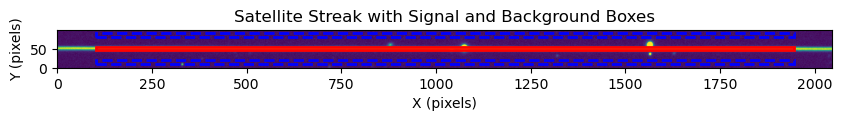


=== Box Vertices ===
Signal Box: [(102, 45), (1944, 45), (1944, 55), (102, 55)]
Background Box 1 (Top): [(102, 10), (1944, 10), (1944, 20), (102, 20)]
Background Box 2 (Bottom): [(102, 80), (1944, 80), (1944, 90), (102, 90)]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

# --- Load image data ---
image_data = np.loadtxt("sample_image.txt")  # Replace with your filename

# --- Contrast for visualization ---
vmin, vmax = np.percentile(image_data, [1, 99])

# --- Image dimensions ---
ny, nx = image_data.shape
pixel_scale = 0.27  # arcsec/pixel


margin = int(0.05 * nx)  # 2% margin on each side
src_x_start = margin
src_x_end   = nx - margin


# --- Define signal (streak) box: long rectangle in center ---

src_y_start = ny // 2 - 5
src_y_end   = ny // 2 + 5


# --- Define background boxes: near top and bottom of image ---
bkg_x_start = src_x_start
bkg_x_end   = src_x_end
bkg1_y_start = 10
bkg1_y_end   = 20

bkg2_y_start = ny - 20
bkg2_y_end   = ny - 10

# --- Extract regions ---
src_region = image_data[src_y_start:src_y_end, src_x_start:src_x_end]
bkg1_region = image_data[bkg1_y_start:bkg1_y_end, bkg_x_start:bkg_x_end]
bkg2_region = image_data[bkg2_y_start:bkg2_y_end, bkg_x_start:bkg_x_end]

# --- Photometry calculations ---
src_counts = np.sum(src_region)
src_area = src_region.size

bkg_counts = np.sum(bkg1_region) + np.sum(bkg2_region)
bkg_area = bkg1_region.size + bkg2_region.size
bkg_mean = bkg_counts / bkg_area

net_src_counts = src_counts - bkg_mean * src_area
surface_brightness_pixel = net_src_counts / src_area
surface_brightness_arcsec = surface_brightness_pixel / (pixel_scale**2)

# --- Print results ---
print("=== Aperture Photometry ===")
print(f"Aperture Counts: {src_counts:.2f}")
print(f"Background Counts: {bkg_counts:.2f}")
print(f"Background Mean (counts/pixel^2): {bkg_mean:.2f}")
print(f"Net Source Counts: {net_src_counts:.2f}")
print(f"Surface Brightness (counts/pixel^2): {surface_brightness_pixel:.2f}")
print(f"Surface Brightness (counts/arcsec^2): {surface_brightness_arcsec:.2f}")

# --- Plot image with boxes ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_data, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title('Satellite Streak with Signal and Background Boxes')
ax.grid(False)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')

# Signal box (red)
signal_box = patches.Rectangle((src_x_start, src_y_start),
                               src_x_end - src_x_start,
                               src_y_end - src_y_start,
                               edgecolor='red', facecolor='none', lw=2, label='Signal')

# Background boxes (blue dashed)
bkg1_box = patches.Rectangle((bkg_x_start, bkg1_y_start),
                             bkg_x_end - bkg_x_start,
                             bkg1_y_end - bkg1_y_start,
                             edgecolor='blue', linestyle='--', facecolor='none', lw=2, label='Background (Top)')

bkg2_box = patches.Rectangle((bkg_x_start, bkg2_y_start),
                             bkg_x_end - bkg_x_start,
                             bkg2_y_end - bkg2_y_start,
                             edgecolor='blue', linestyle='--', facecolor='none', lw=2, label='Background (Bottom)')

# Add patches
for box in [signal_box, bkg1_box, bkg2_box]:
    ax.add_patch(box)

#ax.legend()
plt.show()

# --- Print vertices ---
def box_vertices(x0, x1, y0, y1):
    return [(x0, y0), (x1, y0), (x1, y1), (x0, y1)]

print("\n=== Box Vertices ===")
print("Signal Box:", box_vertices(src_x_start, src_x_end, src_y_start, src_y_end))
print("Background Box 1 (Top):", box_vertices(bkg_x_start, bkg_x_end, bkg1_y_start, bkg1_y_end))
print("Background Box 2 (Bottom):", box_vertices(bkg_x_start, bkg_x_end, bkg2_y_start, bkg2_y_end))


In [9]:
import photutils 


=== Option 2: photutils Aperture Photometry ===
Signal Counts: 9711259.96
Background Mean (counts/pixel²): 266.45
Net Counts: 4472816.53
Surface Brightness (counts/pixel²): 227.51
Surface Brightness (counts/arcsec²): 3120.83


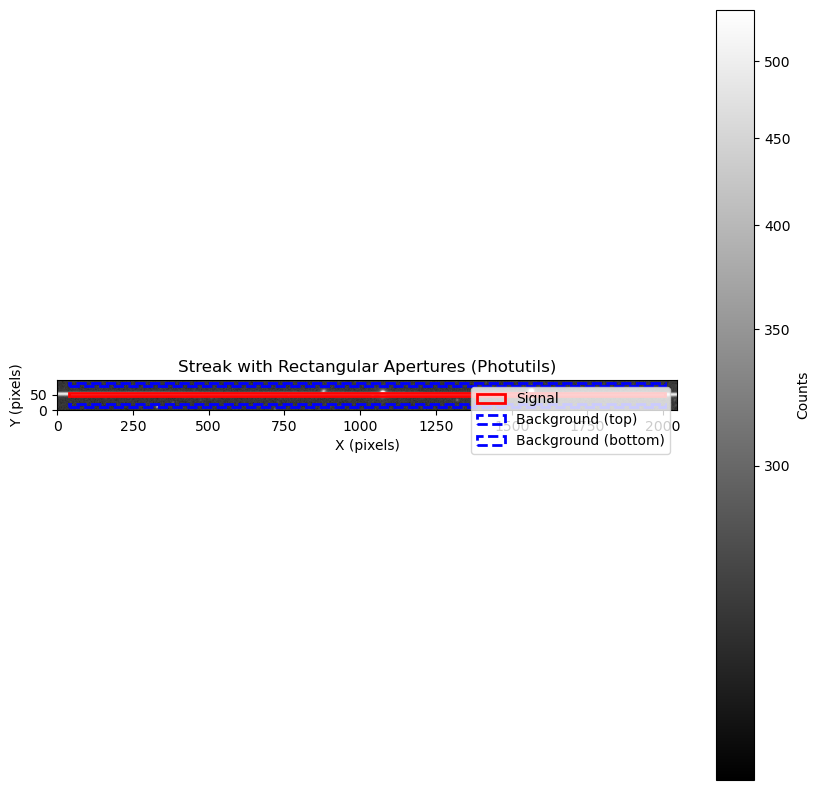


=== Aperture Vertices ===
Signal: [(40.0, 45.0), (2006.0, 45.0), (2006.0, 55.0), (40.0, 55.0)]
Background 1 (top): [(40.0, 10.0), (2006.0, 10.0), (2006.0, 20.0), (40.0, 20.0)]
Background 2 (bottom): [(40.0, 80.0), (2006.0, 80.0), (2006.0, 90.0), (40.0, 90.0)]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import RectangularAperture, aperture_photometry
from astropy.visualization import simple_norm

# --- Load image ---
image_data = np.loadtxt("sample_image.txt")  # Replace with your filename

# --- Image properties ---
ny, nx = image_data.shape
pixel_scale = 0.27  # arcsec/pixel

# --- Display scaling ---
norm = simple_norm(image_data, 'sqrt', percent=99)

# --- Define apertures ---
margin = int(0.02 * nx)
width = nx - 2 * margin  # nearly full width
height = 10  # thickness of the streak

center_x = nx / 2
signal_center = (center_x, ny // 2)
bkg1_center = (center_x, 15)
bkg2_center = (center_x, ny - 15)

signal_ap = RectangularAperture(signal_center, width, height, theta=0)
bkg1_ap = RectangularAperture(bkg1_center, width, height, theta=0)
bkg2_ap = RectangularAperture(bkg2_center, width, height, theta=0)

# --- Do photometry separately ---
phot_signal = aperture_photometry(image_data, signal_ap)
phot_bkg1 = aperture_photometry(image_data, bkg1_ap)
phot_bkg2 = aperture_photometry(image_data, bkg2_ap)

# --- Extract counts ---
signal_total = phot_signal['aperture_sum'][0]
bkg1_total = phot_bkg1['aperture_sum'][0]
bkg2_total = phot_bkg2['aperture_sum'][0]

# --- Background subtraction ---
bkg_total = bkg1_total + bkg2_total
bkg_area = bkg1_ap.area + bkg2_ap.area
bkg_mean = bkg_total / bkg_area

signal_area = signal_ap.area
net_counts = signal_total - bkg_mean * signal_area
surf_brightness_pixel = net_counts / signal_area
surf_brightness_arcsec = surf_brightness_pixel / (pixel_scale ** 2)

# --- Print photutils results ---
print("\n=== Option 2: photutils Aperture Photometry ===")
print(f"Signal Counts: {signal_total:.2f}")
print(f"Background Mean (counts/pixel²): {bkg_mean:.2f}")
print(f"Net Counts: {net_counts:.2f}")
print(f"Surface Brightness (counts/pixel²): {surf_brightness_pixel:.2f}")
print(f"Surface Brightness (counts/arcsec²): {surf_brightness_arcsec:.2f}")

# --- Plot image + apertures ---
plt.figure(figsize=(10, 10))
plt.imshow(image_data, origin='lower', cmap='gray', norm=norm)
signal_ap.plot(color='red', lw=2, label='Signal')
bkg1_ap.plot(color='blue', lw=2, linestyle='--', label='Background (top)')
bkg2_ap.plot(color='blue', lw=2, linestyle='--', label='Background (bottom)')
plt.legend()
plt.title("Streak with Rectangular Apertures (Photutils)")
plt.grid(False)
plt.colorbar(label="Counts")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.show()

# --- Print box vertices ---
def rect_vertices(center, width, height):
    cx, cy = center
    w2, h2 = width / 2, height / 2
    return [(cx - w2, cy - h2), (cx + w2, cy - h2),
            (cx + w2, cy + h2), (cx - w2, cy + h2)]

print("\n=== Aperture Vertices ===")
print("Signal:", rect_vertices(signal_center, width, height))
print("Background 1 (top):", rect_vertices(bkg1_center, width, height))
print("Background 2 (bottom):", rect_vertices(bkg2_center, width, height))


# Aug 22, 2025


=== Aperture Photometry Result ===
Streak center (y0): 49.50 px
Width: σ = 1.51 px, FWHM ≈ 3.55 px
On-streak region: y = [44, 54], 20480 unmasked pixels
Off-streak regions: y = [34, 44] and [54, 64]
Signal sum (masked): 7901547.21
Background level: 264.37 counts/pixel
Empirical background: 5414398.47
Streak flux (signal - background): 2487148.74
Surface brightness: 121.44 counts/pixel²
Surface brightness: 1665.88 counts/arcsec²


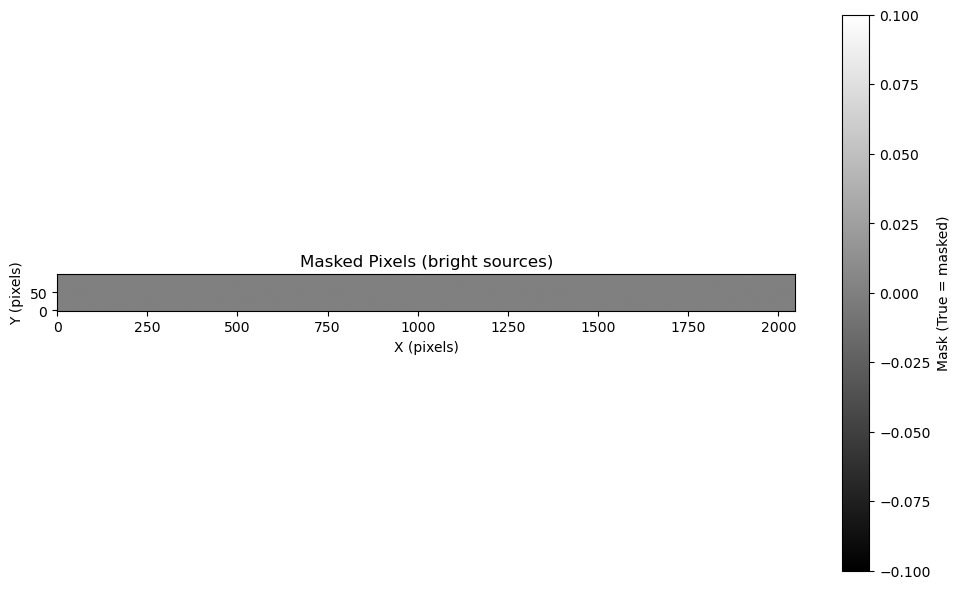

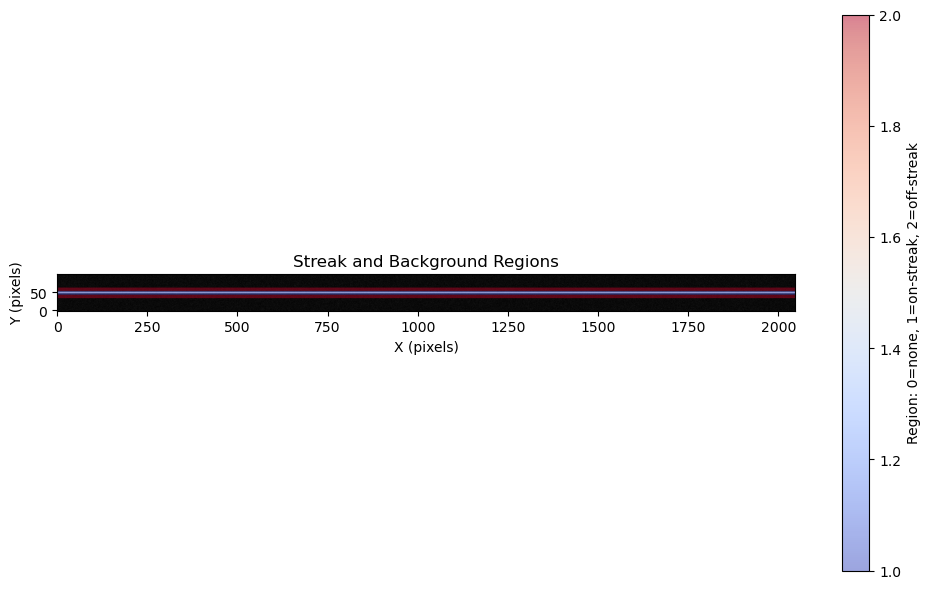

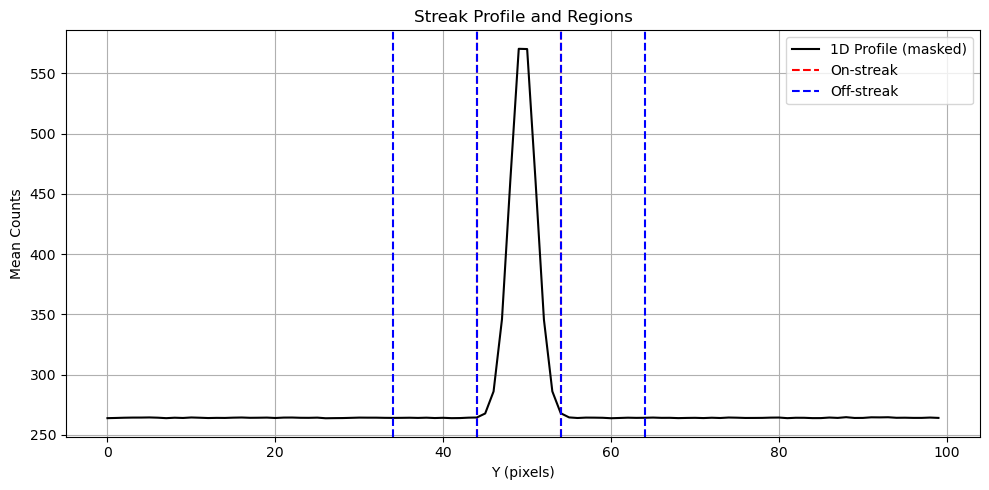

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Load image ---
image_data = np.loadtxt("sample_image.txt")  
image_data = np.loadtxt("simulated_psf_convolved_trail.txt")

# --- Step 1: Mask bright sources ---
median = np.median(image_data)
std = np.std(image_data)
threshold = median + 10 * std
mask = image_data > threshold
masked_data = np.ma.array(image_data, mask=mask)

# --- Step 2: Collapse image to 1D profile across y ---
profile_y = np.ma.mean(masked_data, axis=1)
y = np.arange(len(profile_y))

# --- Step 3: Fit a 1D Gaussian to the profile ---
def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

# Initial guesses
A0 = profile_y.max()
y0 = y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]

popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 4: Define on-streak and off-streak regions ---
on_ymin = int(y0_fit - 3 * sigma_fit)
on_ymax = int(y0_fit + 3 * sigma_fit)
height = on_ymax - on_ymin

off1_ymin = max(0, on_ymin - height)
off1_ymax = on_ymin
off2_ymin = on_ymax
off2_ymax = min(image_data.shape[0], on_ymax + height)

# --- Create region masks for visualization ---
region_mask = np.zeros_like(image_data, dtype=int)
region_mask[on_ymin:on_ymax, :] = 1  # on-streak
region_mask[off1_ymin:off1_ymax, :] = 2  # off-streak below
region_mask[off2_ymin:off2_ymax, :] = 2  # off-streak above

# --- Step 5: Extract pixel values ---
on_region = masked_data[on_ymin:on_ymax, :]
off1_region = masked_data[off1_ymin:off1_ymax, :]
off2_region = masked_data[off2_ymin:off2_ymax, :]

on_sum = on_region.sum()
on_unmasked = np.sum(~on_region.mask)

# --- Step 6: Estimate background ---
off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
off_sum = off1_region.sum() + off2_region.sum()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked

# --- Step 7: Compute final flux and surface brightness ---
streak_flux = on_sum - empirical_bkg
pixel_scale = 0.27  # arcsec/pixel (DECam)
sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / (pixel_scale ** 2)

# --- Print results ---
print("\n=== Aperture Photometry Result ===")
print(f"Streak center (y0): {y0_fit:.2f} px")
print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Signal sum (masked): {on_sum:.2f}")
print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
print(f"Empirical background: {empirical_bkg:.2f}")
print(f"Streak flux (signal - background): {streak_flux:.2f}")
print(f"Surface brightness: {sb_pixel:.2f} counts/pixel²")
print(f"Surface brightness: {sb_arcsec:.2f} counts/arcsec²")

# --- Plot 1: Masked pixels ---
plt.figure(figsize=(10, 6))
plt.imshow(mask, origin='lower', cmap='gray')
plt.title("Masked Pixels (bright sources)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Mask (True = masked)')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 2: Region overlay on original image ---
plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
           origin='lower', cmap='coolwarm', alpha=0.5)
plt.title("Streak and Background Regions")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot 3: 1D profile with region markers ---
plt.figure(figsize=(10, 5))
plt.plot(y, profile_y, label="1D Profile (masked)", color='black')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean Counts")
plt.title("Streak Profile and Regions")
plt.grid(True)
plt.tight_layout()
plt.show()


# Aug 25, 2025

on_sum 7421451.276275635
on_unmasked_pixels 24514
Number of pixel sin background region off streak:  49110
I'm inside the function
regime: background-dominated
Streak flux in electrons 5105759.514039837
Noise background var 51402282.11128791
Noise background std dev 7169.538486631333
Streak flux error in electrons 7169.538486631333
Streak Flux error: 1815.073034590211 (ADU)

=== Aperture Photometry Result ===
Streak center (y0): 49.50 px
Width: σ = 2.14 px, FWHM ≈ 5.05 px
On-streak region: y = [43, 55], 24514 unmasked pixels
Streak flux: 1292597.35
Surface brightness: 723.31 ± 1.02 counts/arcsec² [background-dominated]

=== Aperture Photometry Result ===
Streak center (y0): 49.50 px
Width: σ = 2.14 px, FWHM ≈ 5.05 px
On-streak region: y = [43, 55], 24514 unmasked pixels
Off-streak regions: y = [31, 43] and [55, 67]
Signal sum (masked): 7421451.28
Background level: 250.01 counts/pixel
Empirical background: 6128853.93
Streak flux (signal - background): 1292597.35
Noise regime: background

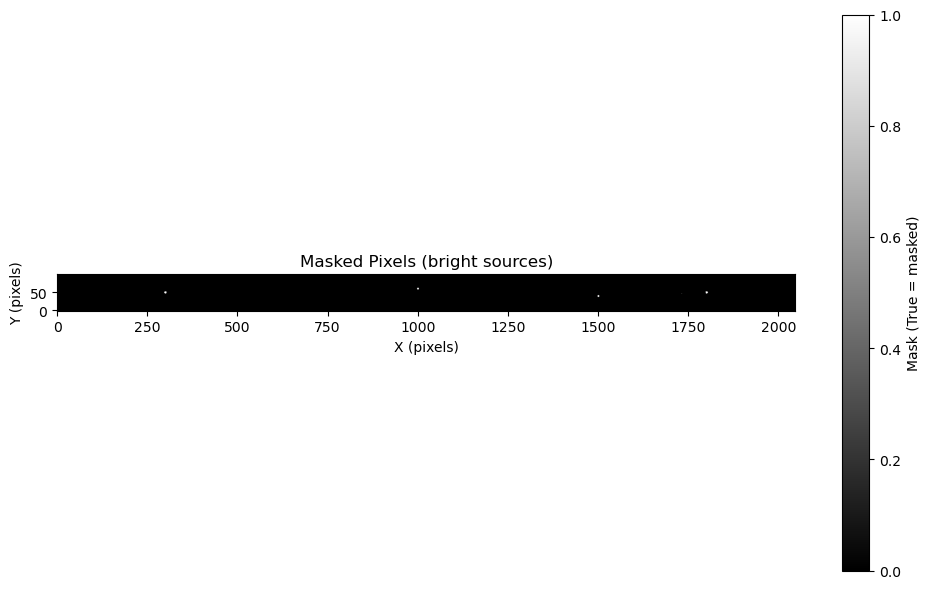

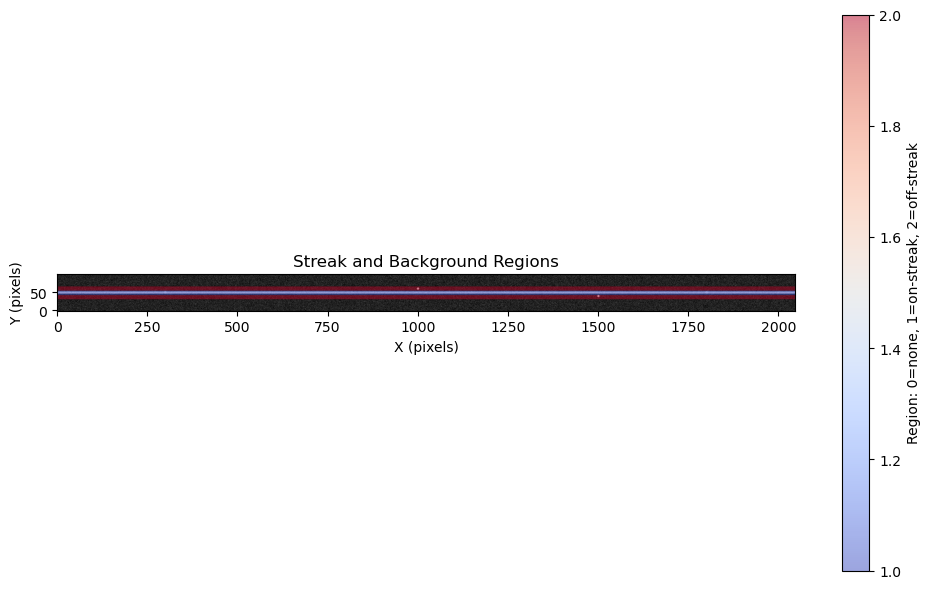

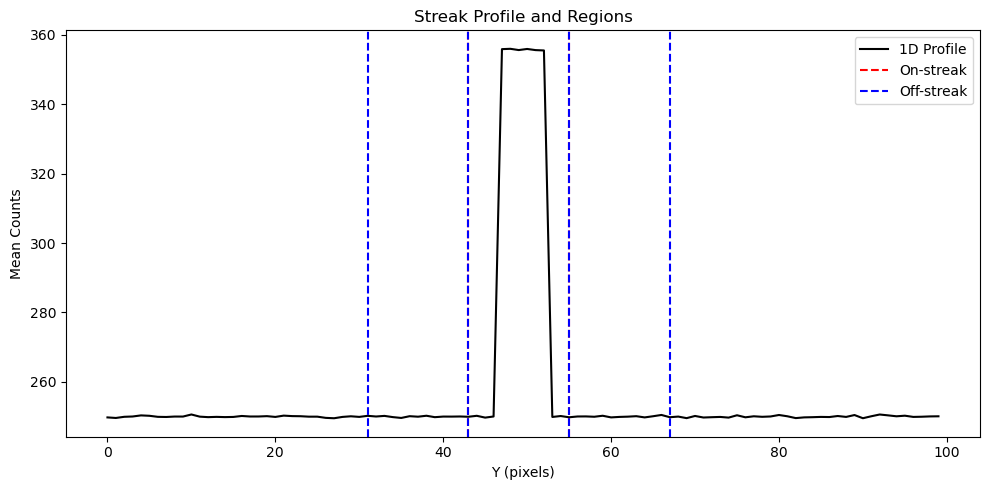

Surface brightness: 22.97 ± 0.00 mag/arcsec²


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.io import fits


def streak_photometry (image_data):
    # For expnum 1103448, detector 26!
    header = {
        "GAINA": 3.95321314938068,
        "GAINB": 3.95211128886414,
        "RDNOISEA": 5.747898,
        "RDNOISEB": 5.928192
    }
    
    #gain = 0.5 * (header["GAINA"] + header["GAINB"])
    #read_noise = 0.5 * (header["RDNOISEA"] + header["RDNOISEB"])

    #From simulated streak
    gain = 3.95                      # e-/ADU
    read_noise = 6.0 


    
    
    # --- Step 1: Mask bright sources ---
    median = np.median(image_data)
    std = np.std(image_data)
    threshold = median + 5 * std
    mask = image_data > threshold
    masked_data = np.ma.array(image_data, mask=mask)
    
    # --- Step 2: Collapse image to 1D profile across y ---
    profile_y = np.ma.mean(masked_data, axis=1)
    y = np.arange(len(profile_y))
    
    # --- Step 3: Fit a 1D Gaussian to the profile ---
    def gaussian(y, A, y0, sigma, offset):
        return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset
    
    A0 = profile_y.max()
    y0 = y[np.argmax(profile_y)]
    sigma0 = 3
    offset0 = np.median(profile_y)
    p0 = [A0, y0, sigma0, offset0]
    popt, _ = curve_fit(gaussian, y, profile_y.filled(offset0), p0=p0)
    A_fit, y0_fit, sigma_fit, offset_fit = popt
    fwhm = 2.355 * sigma_fit
    
    # --- Step 4: Define on-streak and off-streak regions ---
    on_ymin = int(y0_fit - 3 * sigma_fit)
    on_ymax = int(y0_fit + 3 * sigma_fit)
    height = on_ymax - on_ymin
    
    off1_ymin = max(0, on_ymin - height)
    off1_ymax = on_ymin
    off2_ymin = on_ymax
    off2_ymax = min(image_data.shape[0], on_ymax + height)
    
    region_mask = np.zeros_like(image_data, dtype=int)
    region_mask[on_ymin:on_ymax, :] = 1
    region_mask[off1_ymin:off1_ymax, :] = 2
    region_mask[off2_ymin:off2_ymax, :] = 2
    
    # --- Step 5: Extract pixel values ---
    on_region = masked_data[on_ymin:on_ymax, :]
    off1_region = masked_data[off1_ymin:off1_ymax, :]
    off2_region = masked_data[off2_ymin:off2_ymax, :]
    
    on_sum = on_region.sum()
    on_unmasked_pixels = np.sum(~on_region.mask)
    
    print ("on_sum", on_sum)
    print ("on_unmasked_pixels", on_unmasked_pixels)
    
    
    # --- Step 6: Estimate background ---
    off_pixels = np.sum(~off1_region.mask) + np.sum(~off2_region.mask)
    off_sum = off1_region.sum() + off2_region.sum()
    bkg_per_pixel = off_sum / off_pixels
    
    print ("Number of pixel sin background region off streak: ", off_pixels)
    
    empirical_bkg = bkg_per_pixel * on_unmasked_pixels
    
    
    # --- Step 7: Final flux and surface brightness ---
    streak_flux = on_sum - empirical_bkg
    
    
    pixel_scale = 0.27
    
    sb_pixel = streak_flux / on_unmasked_pixels
    sb_arcsec = sb_pixel / (pixel_scale ** 2)
    
    # --- Step 8: Error estimation ---
    def estimate_flux_uncertainty(streak_flux, on_unmasked, bkg_std, gain, read_noise):
        """
        Parameters
        ----------
        streak_flux: `float`
            background-subtracted streak total flux after masking (ADU).
        on_unmasked: `int`
            Number of pixels used to calculate streak flux.
        bkd_std: `float`
            Standard deviation of flux in background region (after masking).
        gain: `float`
            Gain in e/ADU
        read_noise: `float`
            Read noise in e.
    
        Returns
        -------
        flux_err : `float`
            Error in the streak flux (ADU)
        regime: `str`
            Flux or background dominated.  
        """
        flux_e = gain * streak_flux
        bkg_std_e = gain * bkg_std
        
        signal_per_pixel = flux_e / on_unmasked
        noise_background_var = on_unmasked * (bkg_std_e**2 + read_noise**2)
        
        if signal_per_pixel < (5 * bkg_std_e):
            regime = "background-dominated"
            flux_var = noise_background_var
        else:
            regime = "source-dominated"
            flux_var = flux_e + noise_background_var
    
        print ("I'm inside the function")
        print (f"regime: {regime}")
        print (f"Streak flux in electrons {flux_e}")
        print (f"Noise background var {noise_background_var}")
        print (f"Noise background std dev {np.sqrt(noise_background_var)}")
        print (f"Streak flux error in electrons {np.sqrt(flux_var)}")
            
        flux_err = np.sqrt(flux_var) / gain  # back to ADU
    
        
        return flux_err, regime
    
    off_vals = np.hstack([
        off1_region[~off1_region.mask].ravel(),
        off2_region[~off2_region.mask].ravel()
    ])
    
    bkg_std = np.std(off_vals)
    
    streak_flux_err, regime = estimate_flux_uncertainty(streak_flux, on_unmasked_pixels, bkg_std, gain, read_noise)
    
    print(f"Streak Flux error: {streak_flux_err} (ADU)")
    
    
    sb_pixel_err = streak_flux_err / on_unmasked_pixels
    sb_arcsec_err = sb_pixel_err / pixel_scale**2
    
    # --- Output ---
    print("\n=== Aperture Photometry Result ===")
    print(f"Streak center (y0): {y0_fit:.2f} px")
    print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
    print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked_pixels} unmasked pixels")
    print(f"Streak flux: {streak_flux:.2f}")
    print(f"Surface brightness: {sb_arcsec:.2f} ± {sb_arcsec_err:.2f} counts/arcsec² [{regime}]")
    
    
    
    # --- Final Output Summary ---
    print("\n=== Aperture Photometry Result ===")
    print(f"Streak center (y0): {y0_fit:.2f} px")
    print(f"Width: σ = {sigma_fit:.2f} px, FWHM ≈ {fwhm:.2f} px")
    print(f"On-streak region: y = [{on_ymin}, {on_ymax}], {on_unmasked_pixels} unmasked pixels")
    print(f"Off-streak regions: y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
    print(f"Signal sum (masked): {on_sum:.2f}")
    print(f"Background level: {bkg_per_pixel:.2f} counts/pixel")
    print(f"Empirical background: {empirical_bkg:.2f}")
    print(f"Streak flux (signal - background): {streak_flux:.2f}")
    print(f"Noise regime: {regime}")
    
    print(f"Surface brightness: {sb_pixel:.2f} ± {sb_pixel_err:.2f} counts/pixel²")
    print(f"Surface brightness: {sb_arcsec:.2f} ± {sb_arcsec_err:.2f} counts/arcsec²")
    
    
    
    
    # --- Plots ---
    plt.figure(figsize=(10, 6))
    plt.imshow(mask, origin='lower', cmap='gray')
    plt.title("Masked Pixels (bright sources)")
    plt.xlabel("X (pixels)")
    plt.ylabel("Y (pixels)")
    plt.colorbar(label='Mask (True = masked)')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.imshow(image_data, origin='lower', cmap='gray',
               vmin=np.percentile(image_data, 5),
               vmax=np.percentile(image_data, 99))
    plt.imshow(np.ma.masked_where(region_mask == 0, region_mask),
               origin='lower', cmap='coolwarm', alpha=0.5)
    plt.title("Streak and Background Regions")
    plt.xlabel("X (pixels)")
    plt.ylabel("Y (pixels)")
    plt.colorbar(label='Region: 0=none, 1=on-streak, 2=off-streak')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(y, profile_y, label="1D Profile", color='black')
    plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
    plt.axvline(on_ymax, color='red', linestyle='--')
    plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
    plt.axvline(off1_ymax, color='blue', linestyle='--')
    plt.axvline(off2_ymin, color='blue', linestyle='--')
    plt.axvline(off2_ymax, color='blue', linestyle='--')
    plt.legend()
    plt.xlabel("Y (pixels)")
    plt.ylabel("Mean Counts")
    plt.title("Streak Profile and Regions")
    plt.tight_layout()
    plt.show()

    # --- Step 9: Convert to mag/arcsec² using MAGZERO ---
    zeropoint = 30.116  # from header['MAGZERO']

    # Surface brightness in mag/arcsec²
    sb_mag_arcsec2 = zeropoint - 2.5 * np.log10(sb_arcsec)

    # Error propagation
    sb_mag_arcsec2_err = 1.0857 * (sb_arcsec_err / sb_arcsec)

    # Output
    print(f"Surface brightness: {sb_mag_arcsec2:.2f} ± {sb_mag_arcsec2_err:.2f} mag/arcsec²")

    #streak_sb = 1451
    #expected_dilution_factor = (np.sqrt(2 * np.pi) * sigma_fit) / (6 * sigma_fit)  # ~0.45
    #expected_avg_sb = streak_sb * expected_dilution_factor

    #print(f"Expected average SB over 6σ box: {expected_avg_sb:.2f} counts/arcsec²")
    #print(f"Measured SB: {sb_arcsec:.2f} ± {sb_arcsec_err:.2f} counts/arcsec²")


#streak_array = np.loadtxt("sample_image.txt")  # For expnum 1103448, detector 26!

streak_array = np.loadtxt("simulated_flat_streak_image_rec.txt") 
streak_photometry (streak_array)


In [4]:
# --- Step 9: Convert to mag/arcsec² using MAGZERO ---
zeropoint = 30.116  # from header['MAGZERO']

# Surface brightness in mag/arcsec²
sb_mag_arcsec2 = zeropoint - 2.5 * np.log10(sb_arcsec)

# Error propagation
sb_mag_arcsec2_err = 1.0857 * (sb_arcsec_err / sb_arcsec)

# Output
print(f"Surface brightness: {sb_mag_arcsec2:.2f} ± {sb_mag_arcsec2_err:.2f} mag/arcsec²")


NameError: name 'sb_arcsec' is not defined

In [4]:
print(f"Surface brightness: {sb_mag_arcsec2:.5f} ± {sb_mag_arcsec2_err:.5f} mag/arcsec²")


Surface brightness: 22.21141 ± 0.00036 mag/arcsec²


In [5]:
# Step 9: Magnitude and magnitude error (SNR method)

# Convert total flux to electrons
exptime = 90.0  # or header["EXPTIME"]
N_obj = gain * streak_flux  # electrons from object
N_sky = gain * (bkg_per_pixel * on_unmasked)  # electrons from background

# Total noise
sigma_total = np.sqrt(N_obj + N_sky)

# Signal-to-noise ratio
SNR = N_obj / sigma_total

# Magnitude per arcsec² (you already have sb_arcsec)
zeropoint = 30.116  # from header
sb_mag_arcsec2 = zeropoint - 2.5 * np.log10(sb_arcsec)

# Magnitude error using SNR method
sb_mag_arcsec2_err = 1.0857 / SNR

# Output
print(f"\nSurface brightness (mag/arcsec²): {sb_mag_arcsec2:.2f} ± {sb_mag_arcsec2_err:.4f}")
print(f"Signal-to-noise ratio (SNR): {SNR:.1f}")


Surface brightness (mag/arcsec²): 22.21 ± 0.0005
Signal-to-noise ratio (SNR): 2193.5


In [1]:
print ("hola")

hola


### PSF Fitting, 2025SEP23

Before fit

=== Trail Fit Results ===
Background: 250.12
Total flux (phi): 1634495.17 ± 3294.20 ADU
Trail length (L): 2056.32 px
PSF sigma: 2.94 px → FWHM = 6.92 px
Angle θ: 0.00 deg
Center: (1023.48, 49.99)
Surface brightness: 1575.40 ± 3.18 counts/arcsec²


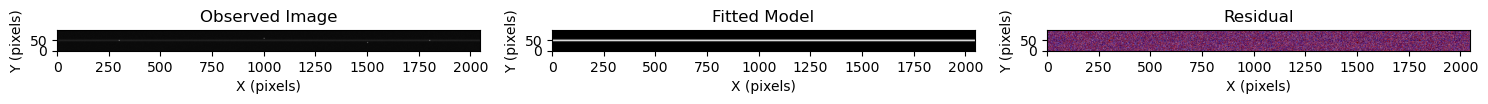

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf

# === Load image ===
image_data = np.loadtxt("simulated_streak_image.txt")
ny, nx = image_data.shape
x_grid, y_grid = np.meshgrid(np.arange(nx), np.arange(ny))

# === Flatten the data for fitting ===
x_flat = x_grid.ravel()
y_flat = y_grid.ravel()
z_flat = image_data.ravel()

# === Equation 3: PSF-convolved trail model ===
def trail_model(coords, b, phi, L, sigma, theta, x0, y0):
    x, y = coords
    sin_t = np.sin(theta)
    cos_t = np.cos(theta)

    # Rotate coordinates
    x_rot = (x - x0) * sin_t + (y - y0) * cos_t
    y_rot = (x - x0) * cos_t - (y - y0) * sin_t

    term1 = b
    term2 = (phi / L) * (1 / (2 * sigma * np.sqrt(2 * np.pi)))
    term3 = np.exp(- (x_rot**2) / (2 * sigma**2))
    Q = y_rot
    erf_arg1 = (Q + L/2) / (sigma * np.sqrt(2))
    erf_arg2 = (Q - L/2) / (sigma * np.sqrt(2))
    term4 = erf(erf_arg1) - erf(erf_arg2)

    return term1 + term2 * term3 * term4

# === Initial guesses ===
b0 = np.median(image_data)
phi0 = np.sum(image_data) - b0 * image_data.size
L0 = 50         # trail length in pixels
sigma0 = 2.0    # seeing width
theta0 = 0.0    # trail along x
x0_0 = nx / 2
y0_0 = ny / 2

p0 = [b0, phi0, L0, sigma0, theta0, x0_0, y0_0]

# === Fit the model ===
bounds = (
    [0,       0,   5, 0.5, -np.pi,    0,    0],  # lower bounds
    [1e5, 1e9, 10000, 10,  np.pi, nx-1, ny-1]      # upper bounds
)

print ("Before fit")
popt, pcov = curve_fit(trail_model, (x_flat, y_flat), z_flat, p0=p0, bounds=bounds, maxfev=5000)
b_fit, phi_fit, L_fit, sigma_fit, theta_fit, x0_fit, y0_fit = popt

# === Estimate uncertainty ===
perr = np.sqrt(np.diag(pcov))
phi_err = perr[1]

# === Convert to SB ===
pixel_scale = 0.27  # arcsec/pixel
trail_area_arcsec2 = L_fit * sigma_fit * 2 * np.sqrt(2*np.log(2)) * pixel_scale**2
sb_arcsec2 = phi_fit / trail_area_arcsec2
sb_arcsec2_err = phi_err / trail_area_arcsec2

# === Output ===
print("\n=== Trail Fit Results ===")
print(f"Background: {b_fit:.2f}")
print(f"Total flux (phi): {phi_fit:.2f} ± {phi_err:.2f} ADU")
print(f"Trail length (L): {L_fit:.2f} px")
print(f"PSF sigma: {sigma_fit:.2f} px → FWHM = {2.355 * sigma_fit:.2f} px")
print(f"Angle θ: {np.degrees(theta_fit):.2f} deg")
print(f"Center: ({x0_fit:.2f}, {y0_fit:.2f})")
print(f"Surface brightness: {sb_arcsec2:.2f} ± {sb_arcsec2_err:.2f} counts/arcsec²")

# === Visualization ===
model_image = trail_model((x_grid, y_grid), *popt).reshape(image_data.shape)

fig, axes = plt.subplots(3, 1, figsize=(15, 5))
axes[0].imshow(image_data, origin='lower', cmap='gray')
axes[0].set_title("Observed Image")
axes[1].imshow(model_image, origin='lower', cmap='gray')
axes[1].set_title("Fitted Model")
axes[2].imshow(image_data - model_image, origin='lower', cmap='seismic', vmin=-10, vmax=10)
axes[2].set_title("Residual")
for ax in axes:
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")
plt.tight_layout()
plt.show()


# === Goodness of fit: chi-square ===
model_flat = model_image.ravel()
data_flat = image_data.ravel()

# Estimate per-pixel noise in counts (ADU)
# Using Poisson + read noise model
noise_adu = np.sqrt(gain * np.clip(model_flat, 0, None) + read_noise**2) / gain
chi2 = np.sum(((data_flat - model_flat) / noise_adu) ** 2)
dof = data_flat.size - len(popt)
chi2_red = chi2 / dof

# === Signal-to-noise ratio ===
snr = phi_fit / phi_err

# === Print additional metrics ===
print(f"\nGoodness of Fit:")
print(f"Chi²: {chi2:.2f}")
print(f"Reduced Chi²: {chi2_red:.2f}")
print(f"SNR (flux / flux_err): {snr:.1f}")



=== Trail Fit Results (θ free) ===
Background: 267.37 counts/pixel
Total flux (phi): 4588351.21 ± 4430.08 ADU
Trail length (L): 2055.28 px
PSF sigma: 3.46 px → FWHM = 8.14 px --> 2.20 arcsec 
Trail angle θ: 0.05 deg
Center: x0 = 1022.71, y0 = 50.63
Surface brightness: 3760.52 ± 3.63 counts/arcsec²
S/N (Eq. 8): 1431.2
Chi²: 250657.78
Reduced Chi²: 11.78


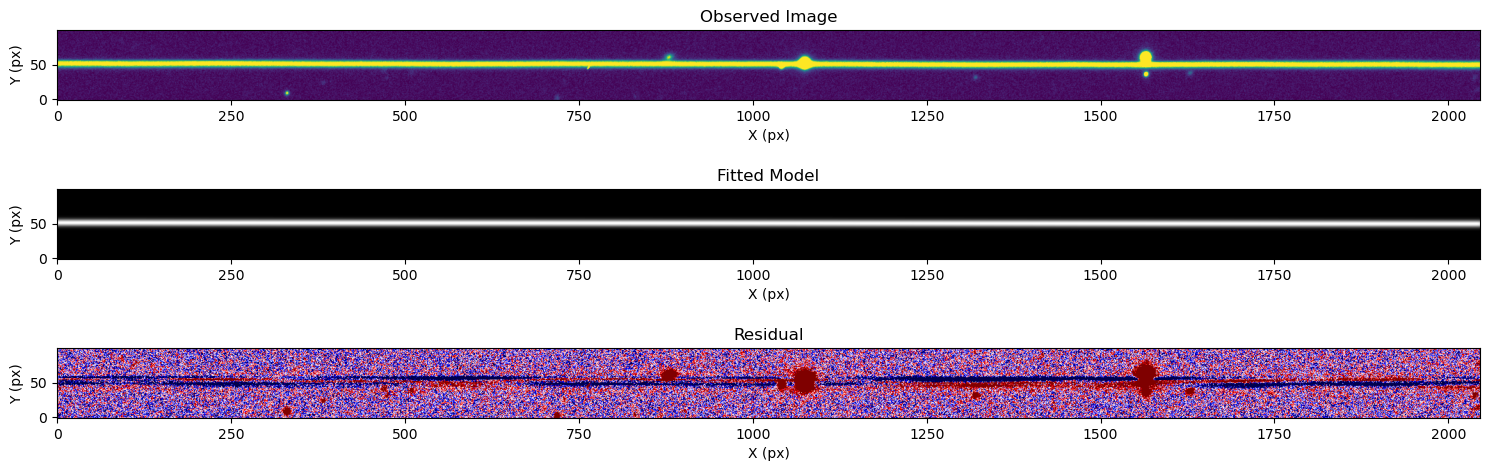

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf

# === Load image ===
#image_data = np.loadtxt("simulated_psf_convolved_trail_low_noise.txt")
image_data = np.loadtxt("sample_image.txt")

# Build a simple bad pixel mask

median = np.median(image_data)
std = np.std(image_data)
threshold = median + 2.5 * std
bp_mask = image_data > threshold


ny, nx = image_data.shape
x_grid, y_grid = np.meshgrid(np.arange(nx), np.arange(ny))
x_flat = x_grid.ravel()
y_flat = y_grid.ravel()
z_flat = image_data.ravel()
mask_flat = bp_mask.ravel()

# Apply mask: exclude masked pixels from fitting
x_flat = x_flat[~mask_flat]
y_flat = y_flat[~mask_flat]
z_flat = z_flat[~mask_flat]


# === Trail model: θ is free ===
def trail_model(coords, b, phi, L, sigma, theta, x0, y0):
    x, y = coords
    sin_t = np.sin(theta)
    cos_t = np.cos(theta)
    x_rot = (x - x0) * sin_t + (y - y0) * cos_t
    Q = (x - x0) * cos_t - (y - y0) * sin_t
    term1 = b
    term2 = (phi / L) * (1 / (2 * sigma * np.sqrt(2 * np.pi)))
    term3 = np.exp(- (x_rot ** 2) / (2 * sigma ** 2))
    erf1 = (Q + L/2) / (sigma * np.sqrt(2))
    erf2 = (Q - L/2) / (sigma * np.sqrt(2))
    return term1 + term2 * term3 * (erf(erf1) - erf(erf2))

# === Initial guess and bounds ===
b0 = np.median(image_data)
phi0 = np.sum(image_data) - b0 * image_data.size
L0 = 2000
sigma0 = 1.0
theta0 = 0.0
x0_0 = nx / 2
y0_0 = ny / 2
p0 = [b0, phi0, L0, sigma0, theta0, x0_0, y0_0]

bounds = ([0, 0, 5, 0.3, -np.pi, 0, 0], [1e9, 1e9, 1e4, 10, np.pi, nx-1, ny-1])

# === Fit ===
popt, pcov = curve_fit(trail_model, (x_flat, y_flat), z_flat, p0=p0, bounds=bounds, maxfev=5000)
b_fit, phi_fit, L_fit, sigma_fit, theta_fit, x0_fit, y0_fit = popt
phi_err = np.sqrt(np.diag(pcov))[1]

# === Reconstruct model ===
model_image = trail_model((x_grid, y_grid), *popt)

# === Define aperture box (aligned to trail angle) ===
length = L_fit + 6 * sigma_fit
width = 3 * sigma_fit
Npix = int(length * width)
pixel_scale = 0.2637 # DECAm plate scale at the center
gain = 3.95
read_noise = 5.8

# Approximate trail aperture mask using rotated bounding box
coords_x = x_grid - x0_fit
coords_y = y_grid - y0_fit
cos_t = np.cos(theta_fit)
sin_t = np.sin(theta_fit)
q = coords_x * cos_t + coords_y * sin_t   # along-trail
r = coords_x * sin_t - coords_y * cos_t   # cross-trail

# Another mask, for the chi2
mask = ((np.abs(q) < length / 2) & (np.abs(r) < width / 2)) & ~bp_mask
ap_data = image_data[mask]
ap_model = model_image[mask]
ap_N = np.sum(mask)

# === Chi² and reduced Chi² ===
noise_var = (gain * ap_model + read_noise**2) / gain**2
chi2 = np.sum((ap_data - ap_model)**2 / noise_var)
chi2_red = chi2 / (ap_N - 7 - 1)

# === S/N from Equation 8: S / sqrt(S + B)
S = phi_fit
B = b_fit * ap_N
snr_eq8 = S / np.sqrt(S + B)

# === Surface brightness ===
# area_arcsec2 = ap_N * pixel_scale**2
psf_fwhm_arcsec = 2.355 * sigma_fit * pixel_scale
area_arcsec2 = L_fit * pixel_scale * psf_fwhm_arcsec

sb_arcsec2 = S / area_arcsec2
sb_arcsec2_err = phi_err / area_arcsec2

# === Print results ===
print("\n=== Trail Fit Results (θ free) ===")
print(f"Background: {b_fit:.2f} counts/pixel")
print(f"Total flux (phi): {phi_fit:.2f} ± {phi_err:.2f} ADU")
print(f"Trail length (L): {L_fit:.2f} px")
print(f"PSF sigma: {sigma_fit:.2f} px → FWHM = {2.355 * sigma_fit:.2f} px --> {2.355 * sigma_fit*pixel_scale:.2f} arcsec ")
print(f"Trail angle θ: {np.degrees(theta_fit):.2f} deg")
print(f"Center: x0 = {x0_fit:.2f}, y0 = {y0_fit:.2f}")
print(f"Surface brightness: {sb_arcsec2:.2f} ± {sb_arcsec2_err:.2f} counts/arcsec²")
print(f"S/N (Eq. 8): {snr_eq8:.1f}")
print(f"Chi²: {chi2:.2f}")
print(f"Reduced Chi²: {chi2_red:.2f}")

# === Plots ===
fig, axes = plt.subplots(3, 1, figsize=(15, 5))
axes[0].imshow(image_data, origin='lower', cmap='viridis',
               vmin=np.percentile(image_data, 5),
               vmax=np.percentile(image_data, 95))
axes[0].set_title("Observed Image")
axes[1].imshow(model_image, origin='lower', cmap='gray')
axes[1].set_title("Fitted Model")

residuals = image_data - model_image
axes[2].imshow(residuals, origin='lower', cmap='seismic', vmin=-10, vmax=10)
axes[2].set_title("Residual")
for ax in axes:
    ax.set_xlabel("X (px)")
    ax.set_ylabel("Y (px)")
plt.tight_layout()
plt.show()



=== Gaussian Fit Parameters ===
A = 254.35, y0 = 50.64, σ = 3.46, FWHM = 8.16, offset = 269.63
χ² = 0.40, reduced χ² = 0.02

=== Aperture Photometry ===
On-streak y = [37, 63], 53030 unmasked pixels
Off-streaks y = [5, 31] and [69, 95]
Streak flux: 4682676.06
Surface brightness: 88.30 counts/pixel², 1211.28 counts/arcsec²


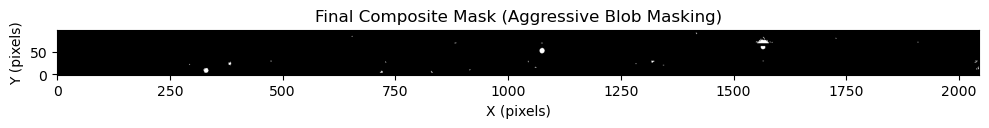

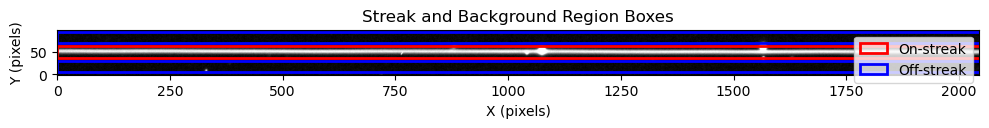

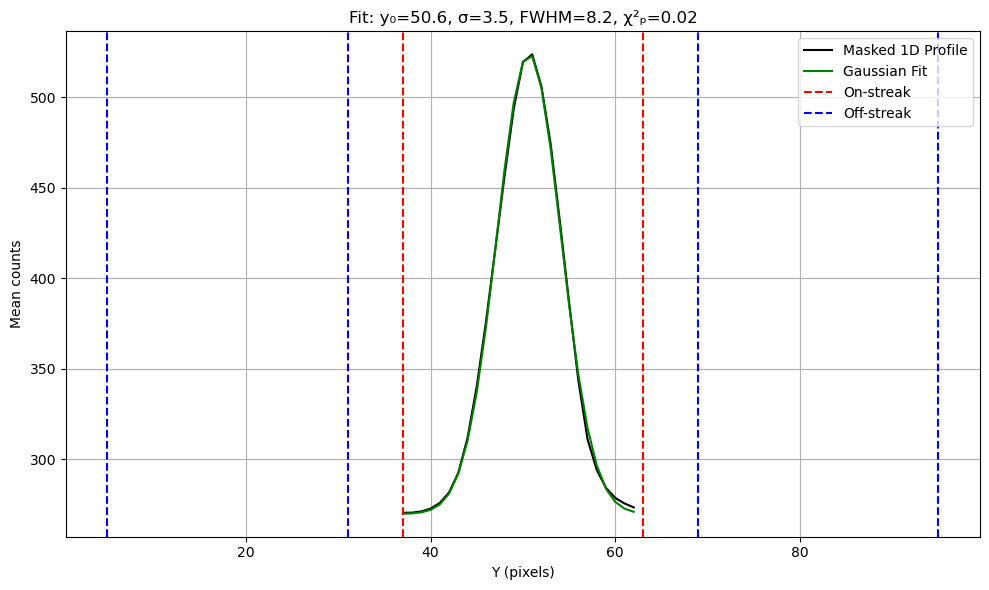

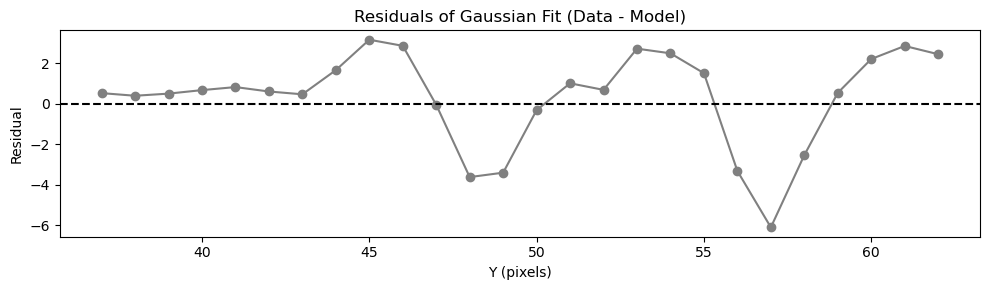

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.ndimage import label

# --- Load image ---
image_data = np.loadtxt("sample_image.txt")  # Replace with your file

# --- Parameters ---
initial_center_y = image_data.shape[0] // 2
initial_width = 20
initial_gap = 10
off_region_scale = 1.5
pixel_scale = 0.27  # arcsec/pixel (DECam)

# --- More aggressive blob masking ---
def improved_region_mask(data, nsigma=2.0, min_blob_area=3):
    """Mask bright blobs per region using sigma clipping + connected components."""
    median = np.median(data)
    std = np.std(data)
    threshold = median + nsigma * std
    bright = data > threshold
    labeled, num = label(bright)
    final_mask = np.zeros_like(data, dtype=bool)
    for i in range(1, num + 1):
        blob = labeled == i
        if blob.sum() >= min_blob_area:
            final_mask |= blob
    return np.ma.masked_where(final_mask, data)

# --- Step 1: Initial region estimate for profile fitting ---
on_ymin = max(0, initial_center_y - initial_width // 2)
on_ymax = min(image_data.shape[0], initial_center_y + initial_width // 2)
on_region = improved_region_mask(image_data[on_ymin:on_ymax, :])

# --- Step 2: Collapse to 1D profile and fit Gaussian ---
profile_y = np.ma.mean(on_region, axis=1)
fit_y = np.arange(on_ymin, on_ymax)

def gaussian(y, A, y0, sigma, offset):
    return A * np.exp(-(y - y0)**2 / (2 * sigma**2)) + offset

A0 = profile_y.max()
y0 = fit_y[np.argmax(profile_y)]
sigma0 = 3
offset0 = np.median(profile_y)
p0 = [A0, y0, sigma0, offset0]

popt, pcov = curve_fit(gaussian, fit_y, profile_y.filled(offset0), p0=p0)
A_fit, y0_fit, sigma_fit, offset_fit = popt
fwhm = 2.355 * sigma_fit

# --- Step 3: Define final regions (±4σ and gaps) ---
streak_half_height = int(4 * sigma_fit)
gap = int(2 * sigma_fit)

on_ymin = max(0, int(y0_fit - streak_half_height))
on_ymax = min(image_data.shape[0], int(y0_fit + streak_half_height))

off_height = 2 * streak_half_height
off1_ymin = max(0, on_ymin - gap - off_height)
off1_ymax = max(0, on_ymin - gap)
off2_ymin = on_ymax + gap
off2_ymax = min(image_data.shape[0], on_ymax + gap + off_height)

# --- Step 4: Final aggressive masking per region ---
on_region = improved_region_mask(image_data[on_ymin:on_ymax, :])
off1_region = improved_region_mask(image_data[off1_ymin:off1_ymax, :])
off2_region = improved_region_mask(image_data[off2_ymin:off2_ymax, :])

# --- Step 5: Photometry ---
on_sum = on_region.sum()
on_unmasked = on_region.count()
off_sum = off1_region.sum() + off2_region.sum()
off_pixels = off1_region.count() + off2_region.count()
bkg_per_pixel = off_sum / off_pixels
empirical_bkg = bkg_per_pixel * on_unmasked
streak_flux = on_sum - empirical_bkg

sb_pixel = streak_flux / on_unmasked
sb_arcsec = sb_pixel / pixel_scale**2

# --- Step 6: Fit diagnostics (using Poisson errors: σ² = data) ---
fit_y = np.arange(on_ymin, on_ymax)
profile_y = np.ma.mean(on_region, axis=1)
model_y = gaussian(fit_y, *popt)
residuals = profile_y - model_y

# Estimate per-pixel variance from unmasked profile
data_var = np.clip(profile_y, 1e-2, None)  # Prevent divide-by-zero
chi2 = np.sum((residuals ** 2) / data_var)
dof = len(profile_y) - len(popt)
red_chi2 = chi2 / dof

# --- Step 7: Final mask for visualization ---
final_mask = np.zeros_like(image_data, dtype=bool)
final_mask[on_ymin:on_ymax, :] |= on_region.mask
final_mask[off1_ymin:off1_ymax, :] |= off1_region.mask
final_mask[off2_ymin:off2_ymax, :] |= off2_region.mask

# === Print results ===
print("\n=== Gaussian Fit Parameters ===")
print(f"A = {A_fit:.2f}, y0 = {y0_fit:.2f}, σ = {sigma_fit:.2f}, FWHM = {fwhm:.2f}, offset = {offset_fit:.2f}")
print(f"χ² = {chi2:.2f}, reduced χ² = {red_chi2:.2f}")

print("\n=== Aperture Photometry ===")
print(f"On-streak y = [{on_ymin}, {on_ymax}], {on_unmasked} unmasked pixels")
print(f"Off-streaks y = [{off1_ymin}, {off1_ymax}] and [{off2_ymin}, {off2_ymax}]")
print(f"Streak flux: {streak_flux:.2f}")
print(f"Surface brightness: {sb_pixel:.2f} counts/pixel², {sb_arcsec:.2f} counts/arcsec²")

# === Plots ===

# Plot 1: Composite Mask
plt.figure(figsize=(10, 6))
plt.imshow(final_mask, origin='lower', cmap='gray')
plt.title("Final Composite Mask (Aggressive Blob Masking)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
#plt.colorbar(label="Masked (True)")
plt.tight_layout()
plt.show()

# Plot 2: Image with Region Boxes
plt.figure(figsize=(10, 6))
plt.imshow(image_data, origin='lower', cmap='gray',
           vmin=np.percentile(image_data, 5), vmax=np.percentile(image_data, 99))
ax = plt.gca()
ax.add_patch(patches.Rectangle((0, on_ymin), image_data.shape[1], on_ymax - on_ymin,
                               edgecolor='red', facecolor='none', lw=2, label='On-streak'))
ax.add_patch(patches.Rectangle((0, off1_ymin), image_data.shape[1], off1_ymax - off1_ymin,
                               edgecolor='blue', facecolor='none', lw=2, label='Off-streak'))
ax.add_patch(patches.Rectangle((0, off2_ymin), image_data.shape[1], off2_ymax - off2_ymin,
                               edgecolor='blue', facecolor='none', lw=2))
plt.title("Streak and Background Region Boxes")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Profile and Fit
plt.figure(figsize=(10, 6))
plt.plot(fit_y, profile_y, label="Masked 1D Profile", color='black')
plt.plot(fit_y, model_y, label="Gaussian Fit", color='green')
plt.axvline(on_ymin, color='red', linestyle='--', label='On-streak')
plt.axvline(on_ymax, color='red', linestyle='--')
plt.axvline(off1_ymin, color='blue', linestyle='--', label='Off-streak')
plt.axvline(off1_ymax, color='blue', linestyle='--')
plt.axvline(off2_ymin, color='blue', linestyle='--')
plt.axvline(off2_ymax, color='blue', linestyle='--')
plt.legend()
plt.xlabel("Y (pixels)")
plt.ylabel("Mean counts")
plt.title(f"Fit: y₀={y0_fit:.1f}, σ={sigma_fit:.1f}, FWHM={fwhm:.1f}, χ²ₚ={red_chi2:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 4: Residuals
plt.figure(figsize=(10, 3))
plt.plot(fit_y, residuals, marker='o', linestyle='-', color='gray')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals of Gaussian Fit (Data - Model)")
plt.xlabel("Y (pixels)")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()
